# Анализ и обработка данных одного куста

## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
#import tensorflow as tf
import matplotlib.pyplot as plt

#from scipy.signal import savgol_filter
from IPython.display import display

from pandas.plotting import autocorrelation_plot

## Константы 

In [2]:
# путь к файлу Excel
path_to_data = 'Данные СТМ Восточный Купол (от 29.01.17)\Куст 201\Скважина 2011.xlsx'

## Описание функций, используемых при анализе и обработке

In [3]:
# чтение данных из файла Excel и возврат датафрейма
def get_df(path):
    file = pd.read_excel(path)
    file.rename(columns = {'Unnamed: 0' : 'Time Moment'}, inplace = True)
    file = file.drop(labels = [0], axis = 0) # удалить вторую строку оглавления
    return file

In [4]:
# вывести 4 графика зависимости значений столбца относительно времени (по графику на столбец)
def draw_4_graphs(df):
    plt.figure(figsize=(22, 20))
    i = 1
    
    for col_name, data in df.items():
        if i != 1:
            plt.subplot(4, 1, i-1)
            #plt.plot(df['Time Moment'].values, data.values, '-')
            plt.plot(df['Time Moment'] , data, '-')
            plt.xlabel('Time Moment')
            plt.ylabel(col_name)
            #plt.xticks(rotation = 45)
            plt.title(col_name)
        i+=1

    plt.show()

In [5]:
# вывести 4 графика box-plot (по графику на столбец)
# не используется
# не уверен, что он полезен тк выбросы удаляются за пределами 0,025 и 0,975 процентных квартилей,
# а эти графики рисуют квартили с 0,25 по 0,75 процентов
def draw_4_box_plot_graphs(df):
    plt.figure(figsize=(22, 20))
    i = 1
    columns = list(df.columns[1:])
    
    for col in columns:
        plt.subplot(4, 1, i)
        #plt.plot(df['Time Moment'] , df[col], '-')
        #autocorrelation_plot(df[col])
        
        df.boxplot(column = col, vert = False)
        
        #plt.xticks(rotation = 45)
        plt.title(col)
        i+=1

    plt.show()

In [6]:
# вывести 4 графика автокорреляции (по графику на столбец)
def draw_4_autocorrelation_graphs(df):
    plt.figure(figsize=(22, 20))
    i = 1
    columns = list(df.columns[1:])
    
    for col in columns:
        plt.subplot(4, 1, i)
        #plt.plot(df['Time Moment'] , df[col], '-')
        autocorrelation_plot(df[col])
        #plt.xticks(rotation = 45)
        plt.xlabel('Time Moment')
        plt.ylabel(col) 
        plt.title(col)
        i+=1

    plt.show()

In [7]:
# нарисовать по 1 графику для каждого столбца, кроме даты, с частотой появления различных значений
def draw_4_frewuencis_graphs(df):
    columns = list(df.columns[1:])
    i = 1
    
    plt.figure(figsize=(16, 10))
    
    for col_name in columns:
        plt.subplot(2, 2, i)
        df[col_name].plot(kind='hist', density=1, bins=20, stacked=False, alpha=.5, color='grey')
        plt.title(col_name)
        i+=1
        
    plt.show()

In [8]:
# нарисовать 6 графиков зависимости каждого столбца от каждого (без повторений)
def draw_6_relations_graphs(df):
    columns = list(df.columns[1:])
    
    plt.figure(figsize=(16, 16))
    
    i = 1
    j = 1
    first_col = columns[0]
    
    for first_col in columns[:-1]:
        for col in columns[j:]:
            plt.subplot(3, 2, i)
            #plt.plot(df[first_col] , df[col], '-') 
            plt.plot(df[first_col] , df[col], 'bx') 
            plt.title(first_col[10:] +  " + " +  col[10:])
            plt.xlabel(first_col)
            plt.ylabel(col)            
            #print(first_col, " + " , col)
            i+=1
        j+=1
        
    plt.show()

In [9]:
# стандартизация данных (от -1 до 1)
# не используется, сделано на будущее
def standartize_data(df):
    i = True
    for col_name, data in df.items():
        if col_name != 'Time Moment': 
            df[col_name] = df[col_name] / df[col_name].max()
    return df

### Функция для обработки данных

В рамках подготовки данных было решено сделать следующие вычисления:
1. Удалить пропуски в данных (строки датафрейма/таблицы где отсутствует хотя бы 1 значение)
2. Удалить строки датафрейма/таблицы где хотя бы у одного элемента значение равняется 0, так как такие значения классифицируются как отсутствие сигнала от прибора из-за того, что о выключен
3. Удалить выбросов в данных.
4. Удалить шумы из данных (предположительно белый шум)

Для удаления выбросов был выбран метод IQR

(Википедия, англ) The interquartile range (IQR), also called the midspread or middle 50%, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1.

In other words, the IQR is the first quartile subtracted from the third quartile; these quartiles can be clearly seen on a box plot on the data.

It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers.
<a>https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba<\>


(Перевод) Межквартильный размах, также называемый межквартильным диапозоном или средним от 50% (формально H-распространение)в статистике - это мера дисперсии, равная разнице между 75% и 25% процентилями, или между нижним и верхним квартилем. Формула для расчета через квартили - IQR = Q3 - Q1.
    
Другими словами IQR - это разность 3 и 1 квартилей, а значения самих квартилей можно увидеть на диаграмме ящика с усами для исследуемых данных.
    
Эта мера идентична стандартному отклонению переменной, однако намного устойчивее к выбросам.

Идея метода - определение правой и левой границ ряда чисел между которыми находятся наиболее вероятные/часто встречаемые числа, а за их пределами числа, встречающиеся реже. Таким образом числа не входящие в диапазон считаются выбросами и удаляются или обрабатываются соответствующим образом.

В данной реализации первый квартиль расчитывался для 2,5%, а третий для 97,5%. Значения выбраны эмпирически. Значения границ высчитывались по формулам:
    
Q1-1.5*IQR - для левой границы;
    
Q3+1.5*IQR - для правой границы.
    
Формулы взяты из статьи выше.
    
Шумы пока что не удаляются

In [10]:
# удалить выбросы из данных методом IQR
def delete_outliers(df):
    columns = list(df.columns[1:])
    for col in columns:
        print('\n\tФильтрация по: ', col)
        row_before = df.shape[0]
        Q1 =  df[col].quantile(0.025)
        Q3 = df[col].quantile(0.975)
        IQR = Q3 - Q1
        df = df[(df[col] > (Q1-1.5*IQR)) & (df[col] < (Q3+1.5*IQR))]
        print('\tУдалено строк: ', row_before - df.shape[0], "\n")
    return df

In [11]:
# подготовка данных
# можно декомпозировать
def prepare_data(df):
    
    row_before = df.shape[0] # количество строк датасета ана предыдущем шаге
    columns = list(df.columns[1:])
    print("Размерноость датасета до обработки: ", df.shape)
    
    #/////////////////////////// удаление пропусков
    print("\nУдаление пропусков данных")
    df.dropna(inplace = True)    
    print("\tУдалено строк: ", row_before - df.shape[0])
    
    #/////////////////////////// удаление нулей
    print("\nУдаление нулевых значений")
    for col in columns:
        df = df.loc[df[col] != 0]
    print("\tУдалено строк: ", row_before - df.shape[0])
    
    #/////////////////////////// удаление выбросов
    print("\nУдаление выбросов")
    df = delete_outliers(df)
    
    print("\nРазмерность датасета после обработки", df.shape)
    
    return df

In [12]:
# описаниие данных
# можно декомпозировать
def describe_data(df):
    columns = list(df.columns[1:])
    
    #/////////////////////////// вывод общей инфы о каждой колонке
    print("Общее описание данных")
    display(df.describe())
    
    #/////////////////////////// вывод матрицы коэффициентов корреляции по Пирсону
    print("Таблица коэффициентов корреляции")
    display(df.corr(method='pearson'))
    
    #/////////////////////////// вывод графиков частоты встречающихся значений
    print("Частота встречающихся значений")
    draw_4_frewuencis_graphs(df)

# Исследование данных до обработки

In [13]:
# чтение данных и приведение столбцов к нужным типам данных
firstDF = get_df(path_to_data)

print(firstDF.dtypes)

columns = list(firstDF.columns[1:]) # взять все колонки кроме даты

for col in columns:
    firstDF[col] = firstDF[col].astype(float)


print("\n", firstDF.dtypes)

print("\n", firstDF.shape)

Time Moment                            object
PT2011-202 (Давление до УР)            object
PT2011-204 (Давление после УР)         object
TT2011-101 (Температура в ТП до УР)    object
FT2011-301-1 (Расход в ТП до УР)       object
dtype: object

 Time Moment                             object
PT2011-202 (Давление до УР)            float64
PT2011-204 (Давление после УР)         float64
TT2011-101 (Температура в ТП до УР)    float64
FT2011-301-1 (Расход в ТП до УР)       float64
dtype: object

 (9361, 5)


In [14]:
# вывод датафрейма до подготовки (всего строк 9361, но выводятся только несколько начальных и конечных)
display(firstDF)

,Time Moment,PT2011-202 (Давление до УР),PT2011-204 (Давление после УР),TT2011-101 (Температура в ТП до УР),FT2011-301-1 (Расход в ТП до УР)
1,2014-12-11 00:00:00,116.536697,112.045097,46.856258,55716.488281
2,2014-12-11 02:00:00,115.591301,112.103897,46.859692,55215.261719
3,2014-12-11 04:00:00,115.929298,112.182198,46.880291,55229.570312
4,2014-12-11 06:00:00,116.546501,112.275299,46.918060,55462.929688
5,2014-12-11 08:00:00,116.198700,112.329201,46.918060,55315.988281
...,...,...,...,...,...
9357,2017-01-28 16:00:00,82.166397,82.470093,45.321579,22623.039062
9358,2017-01-28 18:00:00,82.132118,82.445587,45.163651,22638.109375
9359,2017-01-28 20:00:00,82.318237,82.612129,45.187691,22611.640625
9360,2017-01-28 22:00:00,82.337837,82.631721,45.249489,22575.789062


Общее описание данных


,PT2011-202 (Давление до УР),PT2011-204 (Давление после УР),TT2011-101 (Температура в ТП до УР),FT2011-301-1 (Расход в ТП до УР)
count,9292.000000,9292.000000,9292.000000,9292.000000
mean,106.055068,104.252704,47.489140,31441.511229
std,18.184290,13.657690,3.805488,9277.163173
min,-0.421241,-0.308583,-50.000000,0.000000
25%,99.074799,99.873009,46.904320,25154.277344
50%,108.768200,107.898849,48.095680,27602.485352
75%,114.137823,112.157799,48.861301,37332.399414
max,173.482498,162.270706,50.231178,127115.898438


Таблица коэффициентов корреляции


,PT2011-202 (Давление до УР),PT2011-204 (Давление после УР),TT2011-101 (Температура в ТП до УР),FT2011-301-1 (Расход в ТП до УР)
PT2011-202 (Давление до УР),1.000000,0.764838,0.466869,0.583759
PT2011-204 (Давление после УР),0.764838,1.000000,0.545340,0.523507
TT2011-101 (Температура в ТП до УР),0.466869,0.545340,1.000000,0.435089
FT2011-301-1 (Расход в ТП до УР),0.583759,0.523507,0.435089,1.000000


Частота встречающихся значений


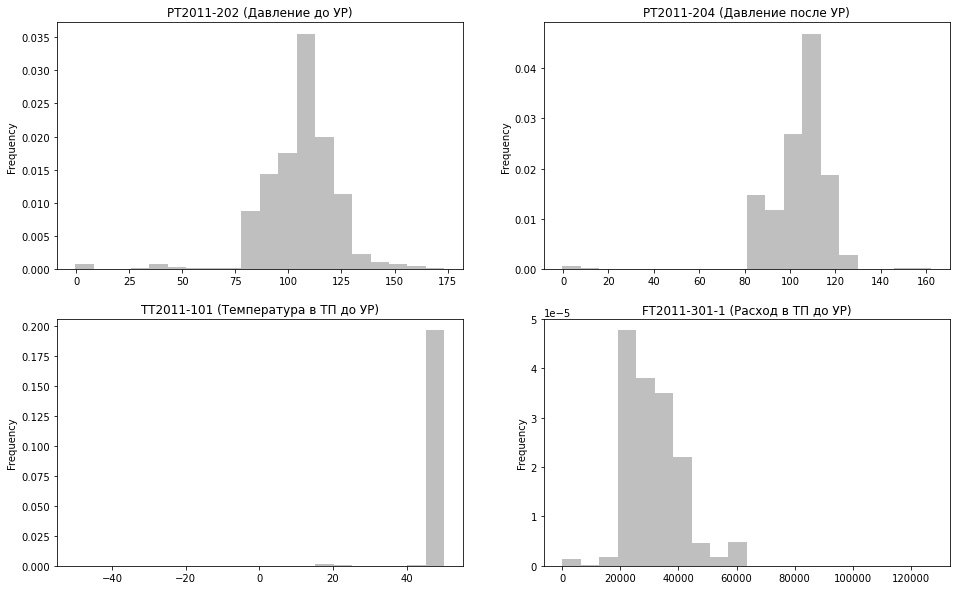

In [15]:
# описание данных до подготовки
describe_data(firstDF)

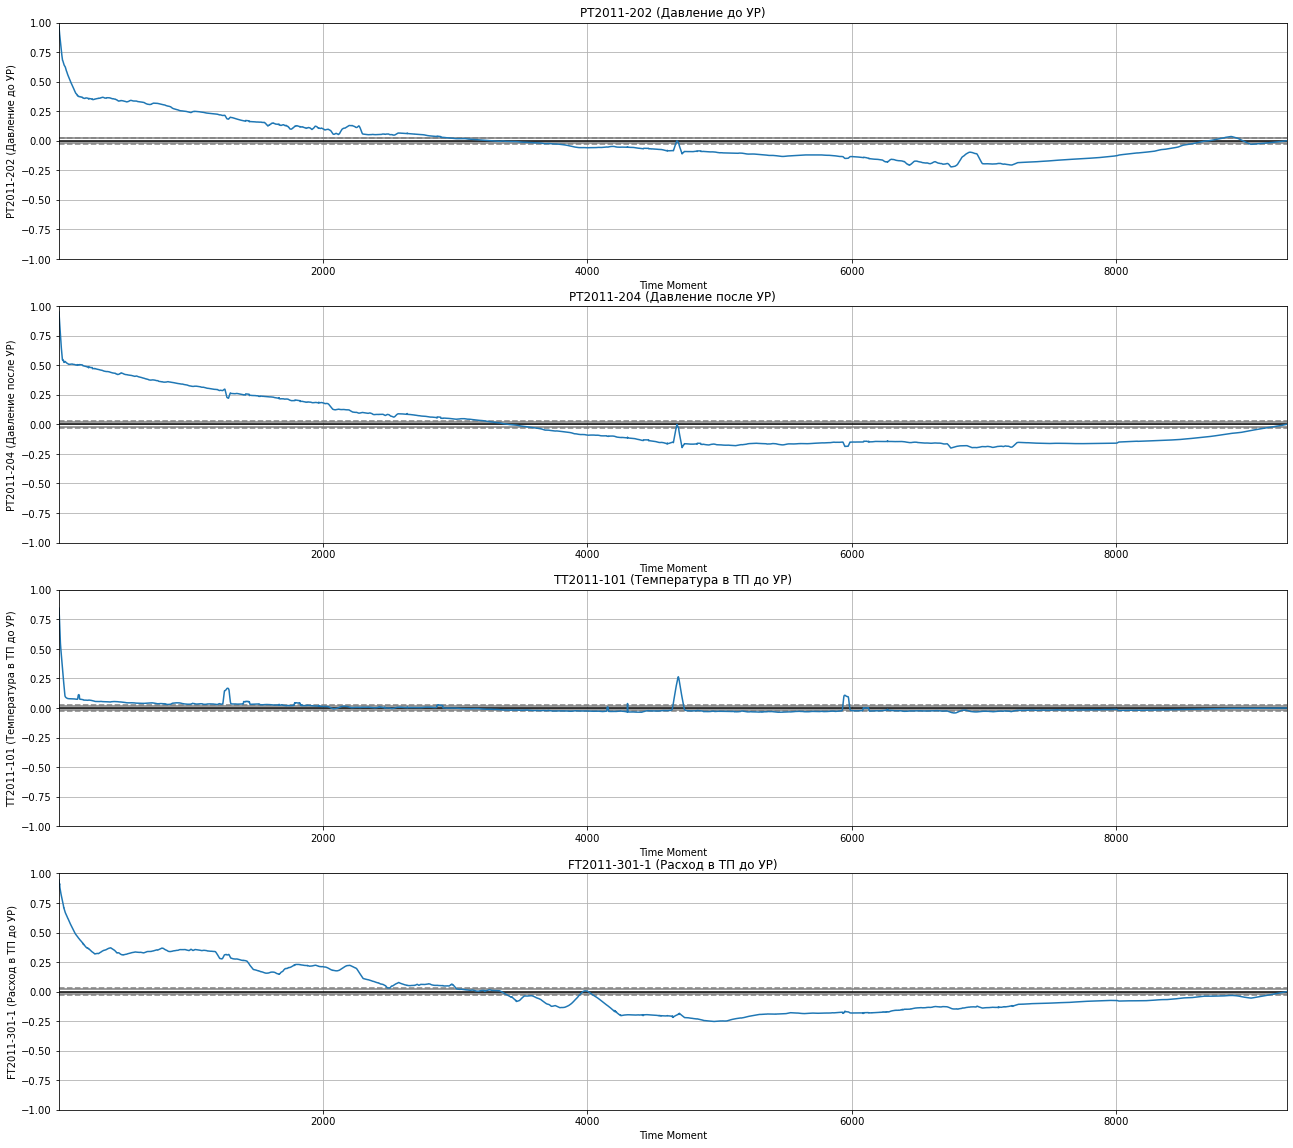

In [24]:
# вывод графиков автокорреляции для не подготовленных данных
# почему то не работает до запуска 21 ячейки (ячейки с обработкой данных), надо запускать после неё вручную
draw_4_autocorrelation_graphs(firstDF)

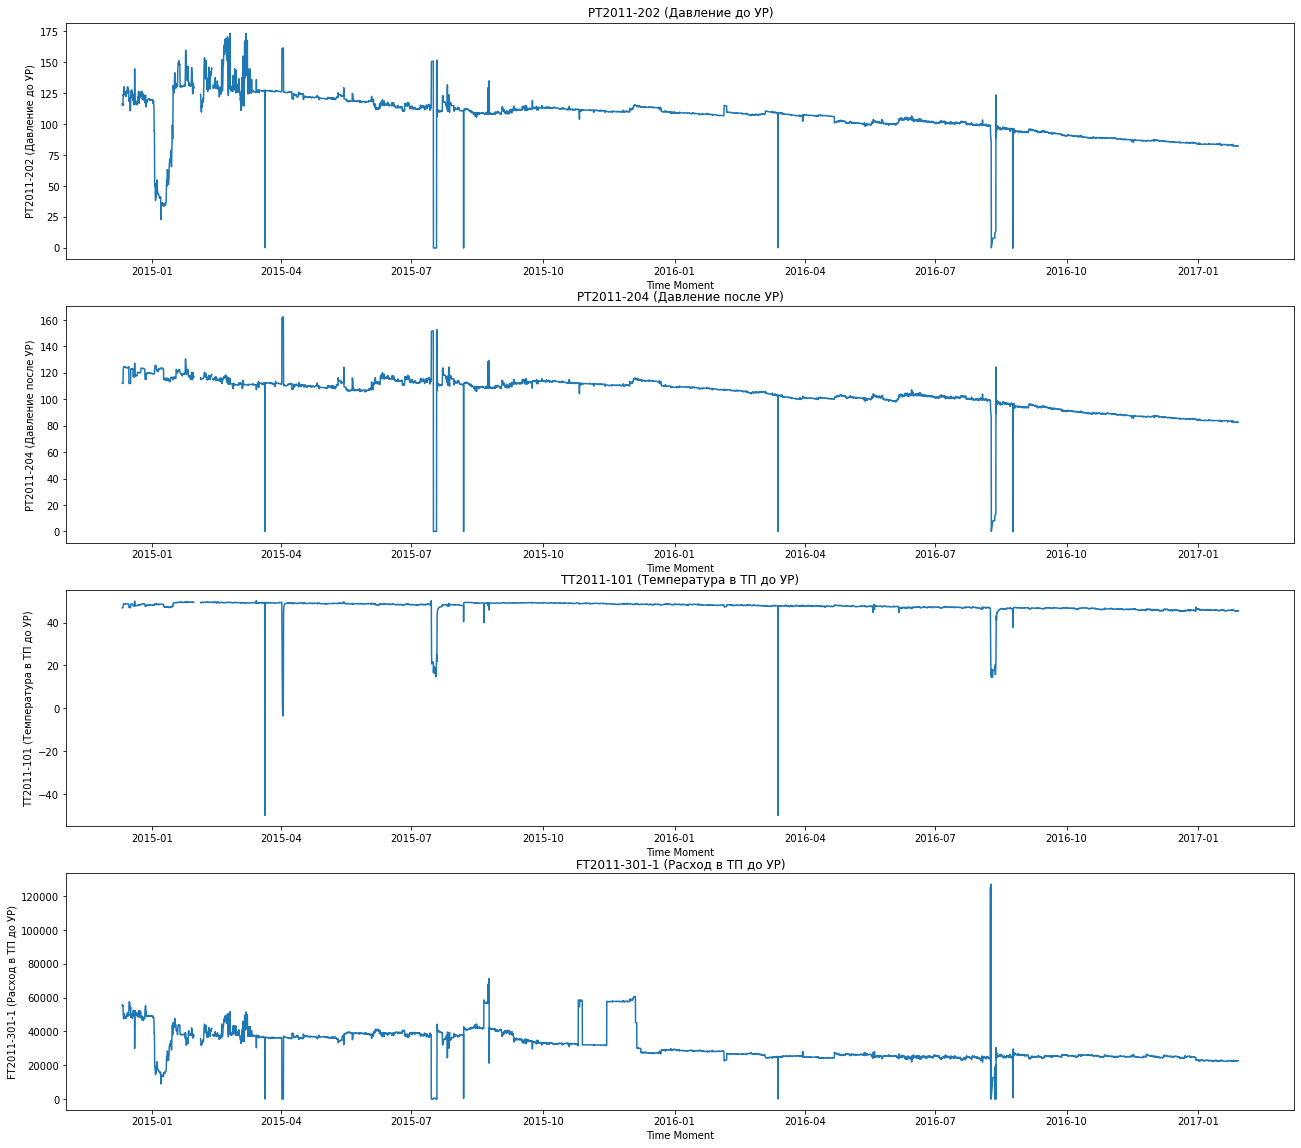

In [17]:
# визуализация данных до подготовки
draw_4_graphs(firstDF)

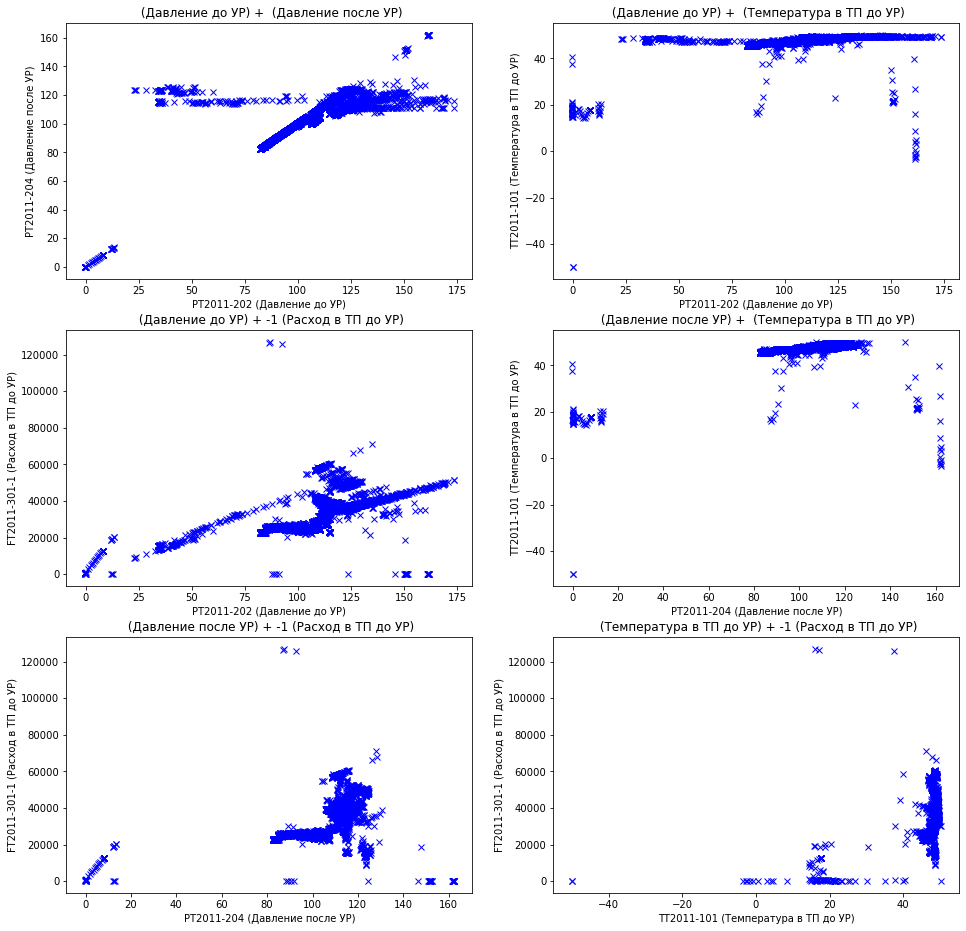

In [18]:
# вывод графиков отношений столбцов датафрейма без повторений для не подготовленных данных 
draw_6_relations_graphs(firstDF)

# Обработка данных

In [19]:
# подготовка данных
Prepared_DF = prepare_data(firstDF)

Размерноость датасета до обработки:  (9361, 5)

Удаление пропусков данных
	Удалено строк:  69

Удаление нулевых значений
	Удалено строк:  81

Удаление выбросов

	Фильтрация по:  PT2011-202 (Давление до УР)
	Удалено строк:  33 


	Фильтрация по:  PT2011-204 (Давление после УР)
	Удалено строк:  35 


	Фильтрация по:  TT2011-101 (Температура в ТП до УР)
	Удалено строк:  33 


	Фильтрация по:  FT2011-301-1 (Расход в ТП до УР)
	Удалено строк:  0 


Размерность датасета после обработки (9179, 5)


## Исследование данных после обработки

Общее описание данных


,PT2011-202 (Давление до УР),PT2011-204 (Давление после УР),TT2011-101 (Температура в ТП до УР),FT2011-301-1 (Расход в ТП до УР)
count,9179.000000,9179.000000,9179.000000,9179.000000
mean,106.670486,104.841485,47.865280,31729.839687
std,15.684636,10.119691,1.154550,8653.859733
min,22.737190,82.406410,39.886700,5.582912
25%,99.417671,99.968712,46.959259,25184.344727
50%,108.827003,107.984497,48.112839,28156.089844
75%,114.114548,112.152901,48.868160,37395.580078
max,173.482498,161.286194,50.231178,71294.703125


Таблица коэффициентов корреляции


,PT2011-202 (Давление до УР),PT2011-204 (Давление после УР),TT2011-101 (Температура в ТП до УР),FT2011-301-1 (Расход в ТП до УР)
PT2011-202 (Давление до УР),1.000000,0.659914,0.732909,0.629698
PT2011-204 (Давление после УР),0.659914,1.000000,0.862881,0.611637
TT2011-101 (Температура в ТП до УР),0.732909,0.862881,1.000000,0.613607
FT2011-301-1 (Расход в ТП до УР),0.629698,0.611637,0.613607,1.000000


Частота встречающихся значений


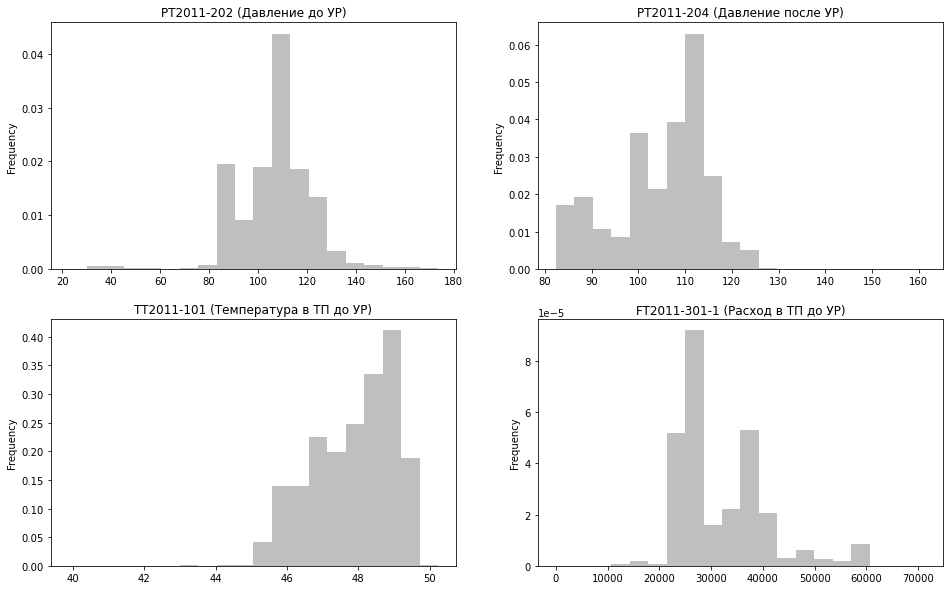

In [20]:
# описание подготовленных данных
describe_data(Prepared_DF)

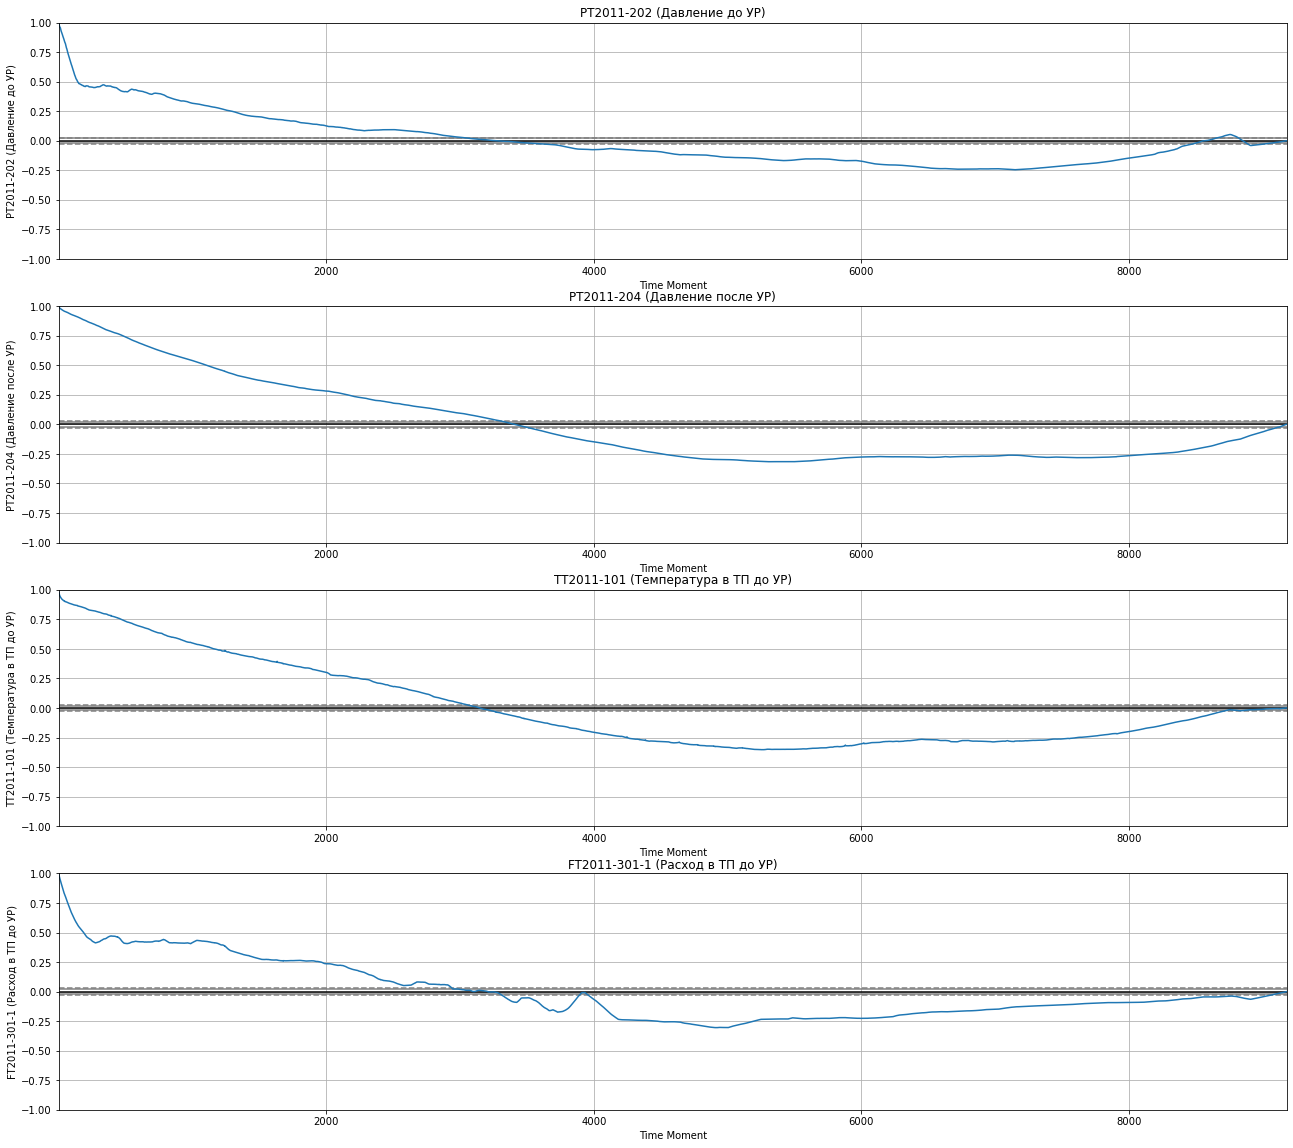

In [21]:
# вывод графиков автокорреляции для подготовленных данных
draw_4_autocorrelation_graphs(Prepared_DF)

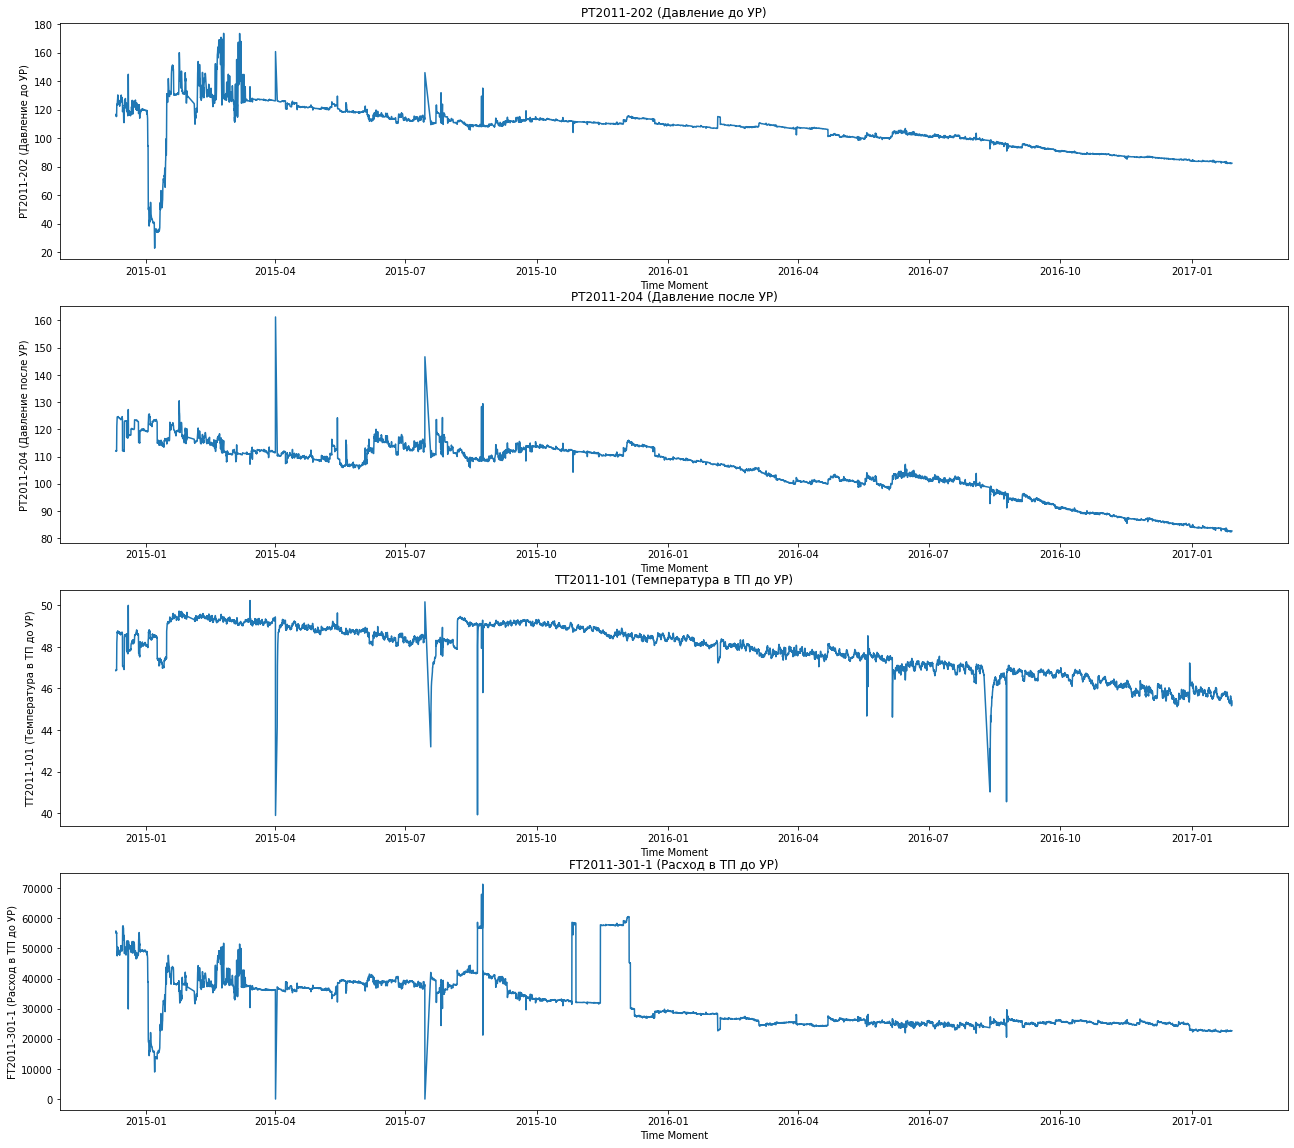

In [22]:
# визуализация подготовленных данных
draw_4_graphs(Prepared_DF)

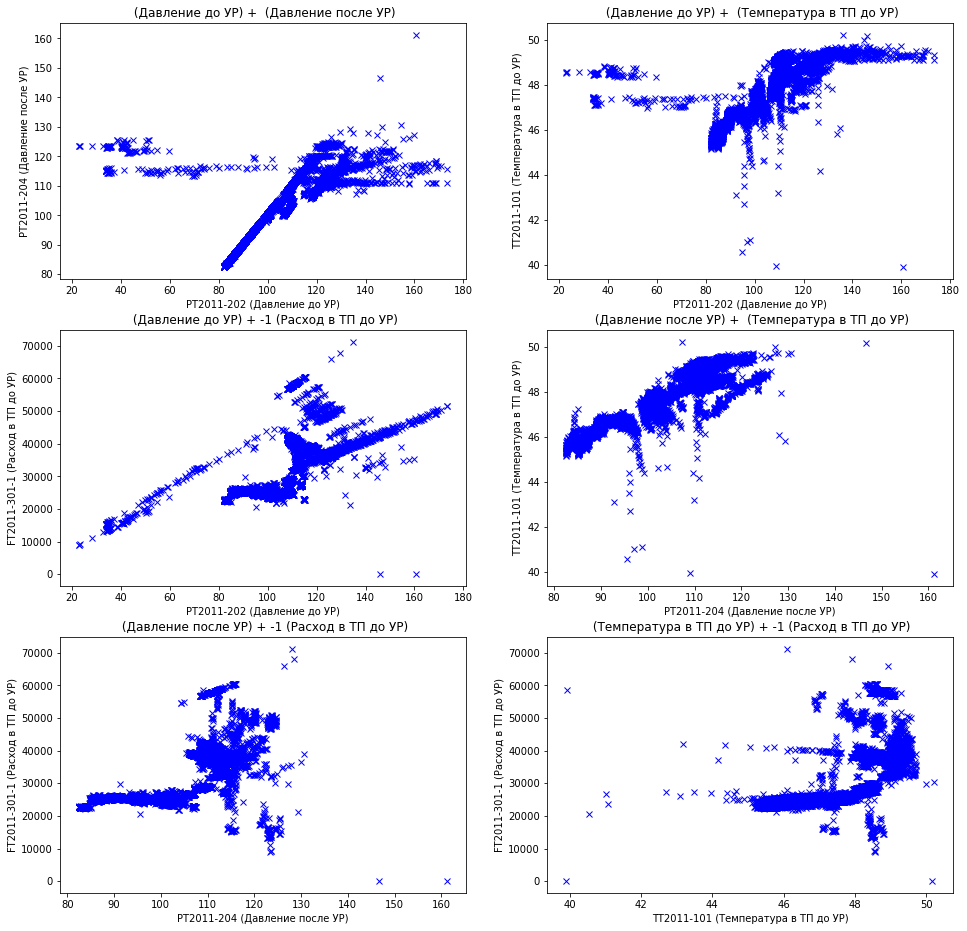

In [23]:
# вывод графиков отношений столбцов датафрейма без повторений для подготовленных данных 
draw_6_relations_graphs(Prepared_DF)

# Выводы

Основной вывод - пригодность данных к использованию в обучении после обработки возросла.

Смотрим на матрицу коэффициентов корреляции данных, видим, что

а) корреляция между всеми столбцами имеется

б) после обработки большинство коэффициентов выросли (скорее всего из-за уменьшения кол-ва выбросов)

(однако расчета доверительных интервалов для этих коэффов и выводов о их стат. значимости сделано не было).

Смотрим на гистограммы частот встречающихся значений, видим, что до обработки в данных были крайне редко встречающиеся значения, портящие общую картину (выбросы). Тот же график температуры - это 2 столба, один мелкий - выбросы, другой большой - все нормольные значения. После обработки (удаления редких значений считай) гистограммы стали выглядеть лучше, даже нормальное распределение напоминают.

Смотрим на коррелограммы, видим, что графики до обработки держатся довольно близко к нулю (а чем ближе к нулю, тем случайнее данные, как я понял), та же температура только редкими выбросами от нуля уходит. После обработки графики от этого нуля весомо отдалились (хотя мб такое поведение как раз выбросами и обусловлено ну или тем загадочным белым шумом).

Смотрим на графики параметров относительно времени до и после, видим, что до обработки температура за краткий временной промежуток может измениться от 40 до -40, хотя по идее должна делать это куда дольше и плавнее (после обработки самый большой скачек - от 49 до 40). Да и вообще по графику и не скажешь общую тенденцию, ибо большая его часть - горизонтальная линия. В целом, то же самое можно и о других сказать. После обработки данные стали выглядеть лучше.

Есть еще кляксообразные графики зависимостей каждой переменной от каждой, но по ним мало что можно сказать, разве что то, что в них можно условно разглядеть графики, описывающие общую тенденцию, что намекает на то, что разработка нейросети для работы с этими данными имеет смысл (кстати после обработки в графиках проще разглядеть тенденции).